# Lab 4: Deep learning in medical imaging

### 1. Introduction

In this lab we are going to use **Deep Learning with Convolutional Neural Network(CNN)**, in order to detect brain hemorrhages of CT images doing a **classification**.

Deep learning is a machine learning method that takes an input X, and uses it to predict an output of Y, so the algorithm will try to **minimize the difference** between its prediction and expected output. One of the most important deep learning architecture is the convolutional neural network (CNN or ConvNet), this **supervised learning** network is able to identify different characteristics in the inputs and then identify different objects. There are five different layers:
- **Input layer**: we take our images as input
- **Convo layer (Convo + activation function)**: to extract features from an input image, also it preserves the relationship between pixels by learning image features using small squares of input data. However, convo layer also contains ReLU activation to make all negative values to zero.
- **Pooling layer**: is used to reduce the spatial volume of input image after convolution, also it is used between two convolution layer
- **Fully connected (FC) layer**: It connects neurons in one layer to neurons in another layer.(Dense Layer) 
- **Sigmoid/logistic layer**: It is used in the last layer for bimodal classification.
- **Output layer**: in this layer we get the labels.


However, in the trials that we have developed in section 3 we have tuned different **hyperparameters** in order to achive a **good performance**, these parameters are the following:
- the dropout rate for the dropout layers
- the number of filters for the convolutional layers
- the number of units for the dense layer
- activation function, for the different models we used the ReLu in the convolutional layers, and in the output layer we have used the sigmoid function

### 2. Preprocesing 

First of all, we need to load the modules, the images and the labels that we are going to use along the notebook.

In addition, we have to take into account that the images could have different sizes, so we will need to normalize them. This is the reason why we are going to create a list, when loading the images, with all the different sizes in order to study them after and choose the best.

In [1]:
import cv2
import os
import csv
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
## Load images

folder = r'C:head-ct-hemorrhage/head_ct/head_ct'

images = []
size = [] #This is the list where we will store all the different sizes

for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename),0)
    images.append(img)
    size.append(img.shape)

In [3]:
## Load labels

with open(r'C:head-ct-hemorrhage/labels.csv', 'r') as file:
    reader = csv.reader(file)
    labels = []
    for row in reader:
        labels.append(row)
labels.pop(0)

['id', ' hemorrhage']

Now, we are going to analyse how different in size the images are with a couple of histograms that will correspond to the distribution of the width and height.

Text(0.5, 1.0, 'Height')

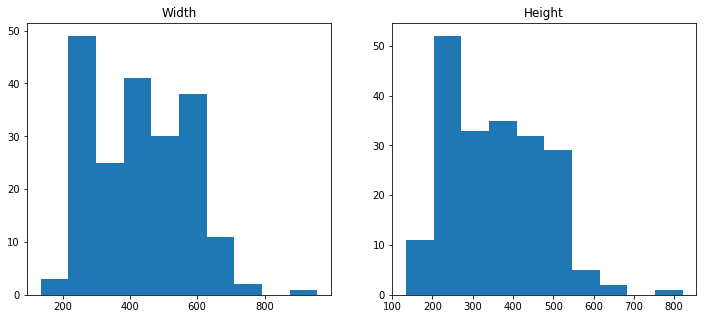

In [4]:
width = []
height = []
for i in size:
    width.append(i[0])
    height.append(i[1])
    
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(width)
plt.title('Width')

plt.subplot(1,2,2)
plt.hist(height)
plt.title('Height')

In [5]:
np.min(size, axis=0)

array([135, 134])

We can observe that there is a big variety of widths and heights, being the most common in both cases between 200 and 300. Therefore, what we are going to do is to transform our images into the **smallest/minimun size** (135,134) in the data set as although we might loose some information, it rounds the average and **the algorithm will work faster and will be more effective**.

On the other hand, we also need to normalize the intensity of our images since the pixels have values from 0 to 255, then we have to make a transformation of each pixel: "value / 255" and we will always have a value between 0 and 1 (black and white).

Thus, to achieve what we have just explained, we will first divide our dataset into train and test. Next, we will create two functions that will help us to normalize either the images and the labels we are going to use or that will be used in the future. 

However, we are aware it exists the function ImageDataGenerator that preprocess the images as we want in a more compact way, but we realised about this after creating the functions so we decided to leave and use them as they also work in a good way.

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(images,labels, test_size = 0.25, random_state=2)

In [7]:
def X_norm(images_set,sizes_set):
    
    min_size = np.min(sizes_set, axis=0)
    X_norm = np.zeros((len(images_set),min_size[0],min_size[1]))

    for i in range(len(images_set)):

        img = cv2.resize(images_set[i], (min_size[1],min_size[0])) #size normalization
        img = img/255.0 #intensity normalization

        X_norm[i] = img
    
    X_norm = X_norm.reshape(len(images_set),min_size[0],min_size[1], 1)
        
    return X_norm

#The labels normalization is just for a matter of dimensionality in order to do not have problems when training 
#and evaluating the model.

def Y_norm(labels_set):
    
    Y_norm = np.zeros((len(labels_set),1))

    for i in range(len(labels_set)):
        Y_norm[i] = labels_set[i][1]
    
    return Y_norm

In [8]:
nX_train = X_norm(X_train, size)
nX_test = X_norm(X_test, size)

nY_train = Y_norm(Y_train)
nY_test = Y_norm(Y_test)

Let's plot some of the images with their corresponding labeling to have an idea of what we have.

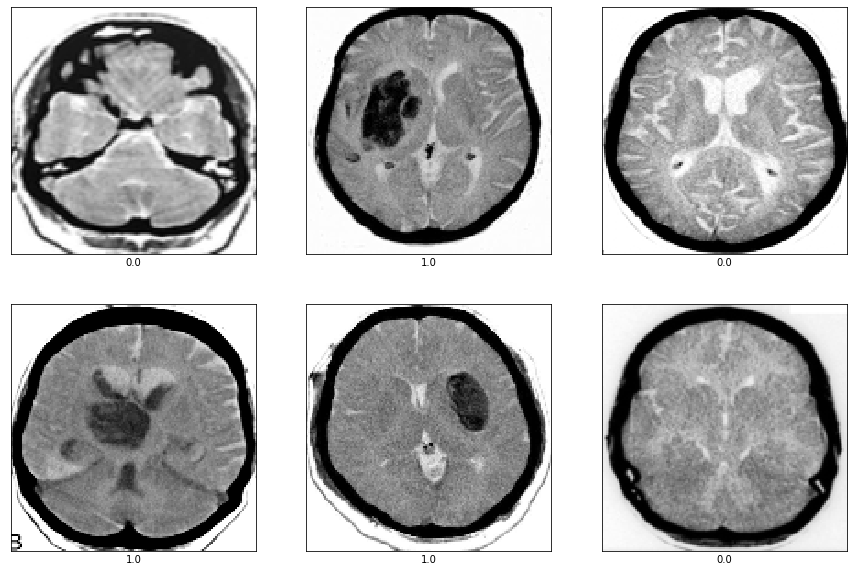

In [9]:
plt.figure(figsize=(15,10))
random_inds = np.random.choice(len(nX_train),6)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(nX_train[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(nY_train[image_ind][0])

### 3. CNN model

As we have seen, deep learning is a very useful tool for classifying images, a very common method is to train an Artifical Neural Network (ANN) for this purpose. However, it can take a lot of time to train it so, this is the reason we finally chose to do it with Convolutional Neural Networks (CNN).

The CNN approach is based on a local understanding of the image. It genetares the enough weights to scan a small area ot the image. [1] But this will better explained when analysing the different layers.

The main challenge of CNNs is to create the model with the appropiate hyperparameters that will work for our images and our goal. Thence, we will show you the different approaches and how they work.

#### 3.1. Trial 1

At first, we will try with the model explained in class but adaptated to a binomial classification. 

In [10]:
t1_model = tf.keras.Sequential([

        tf.keras.layers.Conv2D(filters=24, kernel_size=(3,3), input_shape=(135, 134,1), activation=tf.nn.relu,name='ConvLayer01'),       

        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2,padding='valid'),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(filters=24, kernel_size=(3,3)),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2,padding='valid'),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
    
        tf.keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
t1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ConvLayer01 (Conv2D)         (None, 133, 132, 24)      240       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 66, 66, 24)        0         
_________________________________________________________________
dropout (Dropout)            (None, 66, 66, 24)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 24)        5208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 24)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 24)        0         
_________________________________________________________________
flatten (Flatten)            (None, 24576)             0

Let’s go through this model:


- The first layer uses 24 filters (3 × 3) with an input_shape=[135, 134, 1], because of the images size and because there is a single color channel (i.e., grayscale).


- Next, we have a max pooling layer which uses a pool size of 2, so it divides each spatial dimension by a factor of 2.


- We also add a dropout layer, with a dropout rate of 50% to reduce overfitting.


- Then we repeat the same structure one more time: a convolutional layer followed by a max pooling layer and a dropout layer.


- Finally, there it is the fully connected network, composed of a hidden dense layer and a dense output layer with a sigmoid function, as it is used for binary classifications. Note that we must flatten its inputs, since a dense network expects a 1D array of features for each instance. 

Then, we will use an adam optimizer as it is the one that has given us better results. On the other hand, binary cross entropy will be established as we have a binary classification. This way of compiling will be repeated along the other trials.

In [12]:
t1_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

Finally, we train the model.

In [13]:
#These two variables will be used as callbacks. This way we will be able to get a view on internal states and 
#statistics of the model during training, sharing previous information and avoiding overfitting.

checkpoint_cb = keras.callbacks.ModelCheckpoint("lab4.h5", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [14]:
history = t1_model.fit(nX_train, nY_train, epochs=20, validation_data = (nX_test,nY_test),
                    callbacks=[checkpoint_cb,early_stopping_cb])
t1_model = keras.models.load_model("lab4.h5")

Train on 150 samples, validate on 50 samples
Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
150/150 [==============================] - 3s 22ms/sample - loss: 1.1610 - accuracy: 0.5267 - val_loss: 0.6900 - val_accuracy: 0.5800
Epoch 2/20
150/150 [==============================] - 1s 9ms/sample - loss: 0.6916 - accuracy: 0.5333 - val_loss: 0.6700 - val_accuracy: 0.5400
Epoch 3/20
150/150 [==============================] - 1s 9ms/sample - loss: 0.6369 - accuracy: 0.6067 - val_loss: 0.6629 - val_accuracy: 0.6200
Epoch 4/20
150/150 [==============================] - 1s 9ms/sample - loss: 0.6021 - accuracy: 0.7000 - val_loss: 0.6295 - val_accuracy: 0.6600
Epoch 5/20
150/150 [==============================] - 1s 9ms/sample - loss: 0.5370 - accuracy: 0.8133 - val_loss: 0.6217 - val_accuracy: 0.7000
Epoch 6/20
150/150 [==============================] - 1s 9ms/sample - loss: 0.5000 - accuracy: 0.8267 - val_loss: 0.5959 - val_accuracy: 0.7

In [15]:
t1_model.evaluate(nX_test,nY_test)

50/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.5662030172348023, 0.68]

**Results**

As we can see, this is not suitable for our purpose, we obtain a very high loss and a not enough good accuracy.

#### 3.2. Trial 2

Moreover, we looked for information and ideas of models that could work and we found that we could start from a base that looks like the following.

In [22]:
t2_model = keras.models.Sequential([
    
    keras.layers.Conv2D(32, (5,5), activation = 'relu', input_shape = (135,134, 1)),
    keras.layers.MaxPool2D(2,2),
    
    keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    keras.layers.MaxPool2D((2,2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(1, activation = 'sigmoid')
])

In [23]:
t2_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 131, 130, 32)      832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 65, 65, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               31490560  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

Let's go through this model:


- The first layer uses 32 filters (5 × 5) and then a max pooling layer which uses a pool size of 2.


- Then we repeat the same structure one more time: a convolutional layer followed by a max pooling layer.


- The number of filters grows as we climb up the CNN toward the output layer (it is initially 32, then 64): it makes sense for it to grow, since the number of low-level features is often low.


- Finally, the fully connected network with a hidden dense layer and a dense output layer.  We also add a dropout layer.

Then, we compile and train the model just as before.

In [24]:
t2_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [25]:
history = t2_model.fit(nX_train, nY_train, epochs=20, validation_data = (nX_test,nY_test),
                    callbacks=[checkpoint_cb,early_stopping_cb])
t2_model = keras.models.load_model("lab4.h5")

Train on 150 samples, validate on 50 samples
Epoch 1/20
150/150 [==============================] - 3s 23ms/sample - loss: 2.0730 - accuracy: 0.4533 - val_loss: 0.6481 - val_accuracy: 0.6800
Epoch 2/20
150/150 [==============================] - 2s 15ms/sample - loss: 0.6689 - accuracy: 0.5533 - val_loss: 0.6413 - val_accuracy: 0.6200
Epoch 3/20
150/150 [==============================] - 2s 15ms/sample - loss: 0.6499 - accuracy: 0.5800 - val_loss: 0.6454 - val_accuracy: 0.6400
Epoch 4/20
150/150 [==============================] - 2s 15ms/sample - loss: 0.6028 - accuracy: 0.7533 - val_loss: 0.6063 - val_accuracy: 0.7200
Epoch 5/20
150/150 [==============================] - 2s 16ms/sample - loss: 0.5257 - accuracy: 0.7467 - val_loss: 0.6983 - val_accuracy: 0.5600
Epoch 6/20
150/150 [==============================] - 2s 16ms/sample - loss: 0.5166 - accuracy: 0.7200 - val_loss: 0.7128 - val_accuracy: 0.6600
Epoch 7/20
150/150 [==============================] - 3s 21ms/sample - loss: 0.4234 -

In [26]:
t2_model.evaluate(nX_test,nY_test)

50/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.5607158505916595, 0.74]

**Results**

As we can see, we are getting closer but the accuacy is still not high enough, it seems we can improve it. Therefore, we decided not to choose this as our final model as we think we can get better results.

#### 3.3. Final trial

Finally, we modified some of the hyperparameters from the last model.

In [37]:
model = keras.models.Sequential([
    
    keras.layers.Conv2D(24, (3,3),strides=1, activation = 'relu',input_shape = (135,134, 1)),
    keras.layers.MaxPool2D((2,2)),
    
    keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    keras.layers.MaxPool2D((2,2)),
    
    keras.layers.Conv2D(64, (3,3),activation = 'relu'),
    keras.layers.MaxPool2D(2,2),
    
    keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    keras.layers.MaxPool2D((2,2)),
    
    keras.layers.Conv2D(256, (3,3), activation = 'relu'),
    keras.layers.MaxPool2D((2,2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.3),
     
    keras.layers.Dense(1, activation = 'sigmoid')
])

In [38]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 133, 132, 24)      240       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 66, 66, 24)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 32)        6944      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 128)      

Let's go through this model:


- As it follows the same structure as before, we have a convolutional layer followed by a max pooling layer five times. But this time, the first layer uses 24 filters (3 × 3) with a stride and we have been increasing the filter size until 256.


- Finally, we changed the number of neurons of the hidden dense layer to 128 as the previous number was very high.

In [39]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [40]:
history = model.fit(nX_train, nY_train, epochs=30, validation_data = (nX_test,nY_test),
                    callbacks=[checkpoint_cb,early_stopping_cb])
model = keras.models.load_model("lab4.h5")

Train on 150 samples, validate on 50 samples
Epoch 1/30
150/150 [==============================] - 4s 24ms/sample - loss: 0.7109 - accuracy: 0.5333 - val_loss: 0.6814 - val_accuracy: 0.5400
Epoch 2/30
150/150 [==============================] - 1s 9ms/sample - loss: 0.6840 - accuracy: 0.5133 - val_loss: 0.6713 - val_accuracy: 0.5200
Epoch 3/30
150/150 [==============================] - 1s 9ms/sample - loss: 0.6519 - accuracy: 0.6733 - val_loss: 0.6099 - val_accuracy: 0.6800
Epoch 4/30
150/150 [==============================] - 1s 9ms/sample - loss: 0.5413 - accuracy: 0.7533 - val_loss: 0.4316 - val_accuracy: 0.8400
Epoch 5/30
150/150 [==============================] - 1s 9ms/sample - loss: 0.5453 - accuracy: 0.7000 - val_loss: 0.3942 - val_accuracy: 0.7800
Epoch 6/30
150/150 [==============================] - 1s 9ms/sample - loss: 0.3889 - accuracy: 0.8133 - val_loss: 0.3947 - val_accuracy: 0.8400
Epoch 7/30
150/150 [==============================] - 1s 9ms/sample - loss: 0.3694 - accur

In [41]:
model.evaluate(nX_test,nY_test)

50/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.3448847389221191, 0.88]

**Results**

As we can see, we finally obtain a very good accuracy getting to 0.88. For this reason, we decided to choose this as our final model.

On the other hand, we have to consider the models depends a lot on which is the image set that is training the model. This means that depending which images train the model, we will obtain higher o lower accuracy. Nevertheless, after several trials, we found the accuracy with this CNN is between 0.86 and 0.92.

In order to visualize this model and explain the selection of 25 epochs, we are going to **plot accuracy and loss value with respect to the different number of epoch**.

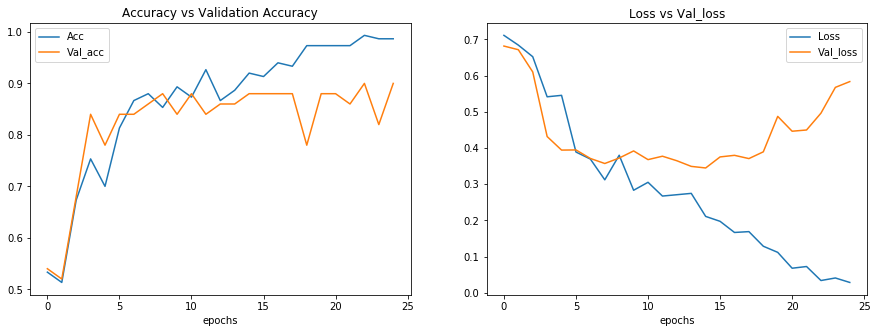

In [42]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(history.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

Regarding the graph we can see how **accuracy** (for train and validation) is **exponentially increasing when we increase epoch**. **However**, this value gets an maximum accuracy when it is close to **25-30 epochs**. For this reason, we are going to use 30 epochs.

In terms of **loss value** we see how **it reaches a very low value when the number of epochs increases**. However **close to 30 epochs the difference between train and validation loss value** is quite importnat.

However, establishing a **trade-off between accuracy and loss value** we decide to choose an epoch of 30.

### 4. Predictions

In [44]:
# With model created we predict the test set of our database.

predicted_classes = model.predict_classes(nX_test)

# Comparing the prediced results with the real ones we are going to create two lists in which images index will be
#introduced depending if they have been well-predicted or not.
correct_indices = []
incorrect_indices = []

for i in range(len(predicted_classes)):
    if predicted_classes[i] == int(Y_test[i][1]):
        correct_indices.append(i)
    else:
        incorrect_indices.append(i)

In [45]:
print(correct_indices)

[0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 48, 49]


In [46]:
print(incorrect_indices)

[1, 8, 18, 22, 39, 41]


As it can be seen thanks to the previous lists **a lot of images have been well-predicted with our model**. However, as model does not get a 1 value of accuracy, there are some images that are not well-predicted. In our case we have 50 test images, 6 of them have not been well-predicted and 44 are well-predicted. **These results show the model works quite well**.

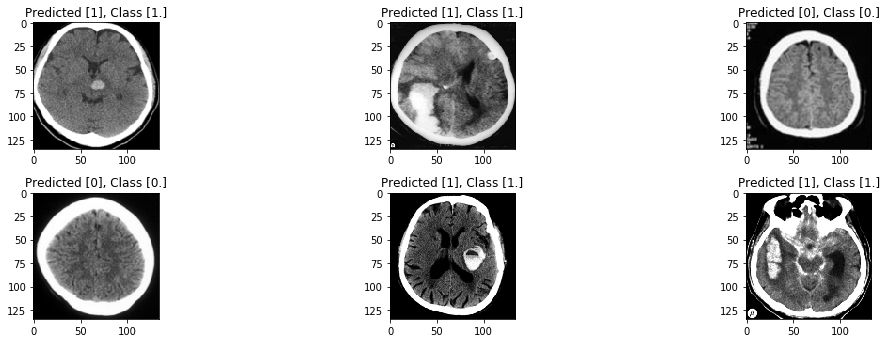

In [47]:
plt.figure(figsize=(15,7))
for i, correct in enumerate(correct_indices[9:15]):
    plt.subplot(3,3,i+1)
    plt.imshow(nX_test[correct].reshape(135, 134), cmap='gray')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], nY_test[correct]))
    
plt.tight_layout()

Above it can be seen 6 of the **images that have been well-predicted**. The predicted class corresponds with the actual one.

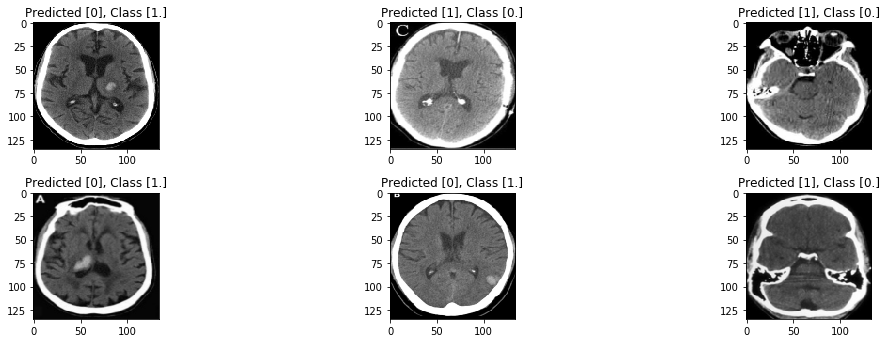

In [48]:
plt.figure(figsize=(15,7))

for i, incorrect in enumerate(incorrect_indices):
    plt.subplot(3,3,i+1)
    plt.imshow(nX_test[incorrect].reshape(135, 134), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], nY_test[incorrect]))
    
plt.tight_layout()

In these images; however, it can be seen **the 6 images of the whole database that have not been correctly predicted**. It can be seen how predicted class doesn't correspond to the actual one.

### 5. Conclusions

As it has been concluded thanks to the predictions of our database, the model that we have created is very useful in order to **determine if an CT image presents hemorrhage or not**. 

This model could also be modified and **applied to another medical fields or to other disease detections** such as the final project created by this group that was focus on the detection of COVID-19 pneumonia in X-ray images.

In spite of the fact that our model works well in this case, it could work better and be applied to more important and decisive medical fields.

On the other hand, the project has been performed in low scale. Then, although the accuracy reached is 0.88, this metric could be higher with more time and more complex tools.

Thanks to the application of better techniques and technologies and to the possibility of performing the problem in more time, this initial model or algorithm could be highly implemented.

The impact these algorithms can have in the health sector is really important. It could be of help for the doctors to have a tool in which they can ensure their diagnosis. Besides, it would be a help method for researching and development

### References

[1] https://missinglink.ai/guides/convolutional-neural-networks/convolutional-neural-networks-image-classification/